In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET # Parse xml files
import csv

/Users/alex/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Load directories
images_dir  = 'dataset/IMG/'
annotation_dir = 'dataset/XML/'

In [ ]:
# sample_image = Image.open('dataset/IMG/Pothole-001.jpg')
# imgplot = plt.imshow(sample_image)
# plt.show()

In [3]:
# https://www.kaggle.com/code/mtszkw/reading-sample-image-and-bounding-boxes-from-xml/notebook
# Map XML to corresponding Image
def parse_voc_annotation(annotation_dir, image_dir):
    dataset = []
    for file in os.listdir(annotation_dir):
        tree = ET.parse(os.path.join(annotation_dir, file))
        root = tree.getroot()
        filename = root.find("filename").text
        image_path = os.path.join(image_dir, filename) # Find image using filename

        boxes = []
        for neighbor in root.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)
            boxes.append((xmin, ymin, xmax, ymax))

        dataset.append({"image": image_path, "boxes": boxes})

    return dataset

In [4]:
# Create dataset
dataset = parse_voc_annotation(annotation_dir, images_dir)
print(dataset[:5])

[{'image': 'dataset/IMG/Pothole-083.jpg', 'boxes': [(147, 331, 313, 574), (76, 111, 148, 170), (0, 1, 91, 136)]}, {'image': 'dataset/IMG/Pothole-097.jpg', 'boxes': [(135, 1, 232, 64), (24, 93, 342, 654)]}, {'image': 'dataset/IMG/Pothole-068.jpg', 'boxes': [(121, 249, 181, 375)]}, {'image': 'dataset/IMG/Pothole-040.jpg', 'boxes': [(48, 83, 345, 736)]}, {'image': 'dataset/IMG/Pothole-054.jpg', 'boxes': [(101, 58, 543, 309)]}]


In [5]:
# Draw bounding boxes in images (i.e. around potholes)
def draw_image_with_boxes(ax, image, boxes, title="Image"):
    ax.imshow(image)
    for (xmin, ymin, xmax, ymax) in boxes:
        # Draw bounding box
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            linewidth=2, 
            edgecolor='red', 
            facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_title(title)
    ax.axis("off")

# Visualise both images side-by-side
def compare_images(original_image, original_boxes, resized_image, resized_boxes):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    draw_image_with_boxes(axes[0], original_image, original_boxes, title="Original Image")
    draw_image_with_boxes(axes[1], resized_image, resized_boxes, title="Resized Image")
    plt.tight_layout()
    plt.show()

In [6]:
# Preprocess images
def preprocess_image(image_path, boxes, target_size=(416,416)):
    image = Image.open(image_path)
    width, height = image.size

    # Resize images
    resized_image = image.resize(target_size)
    scale_x = target_size[0] / width
    scale_y = target_size[1] / height

    # Adjust bounding boxes
    resized_boxes = []
    for (xmin, ymin, xmax, ymax) in boxes:
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)
        resized_boxes.append((xmin, ymin, xmax, ymax))

    return resized_image, resized_boxes

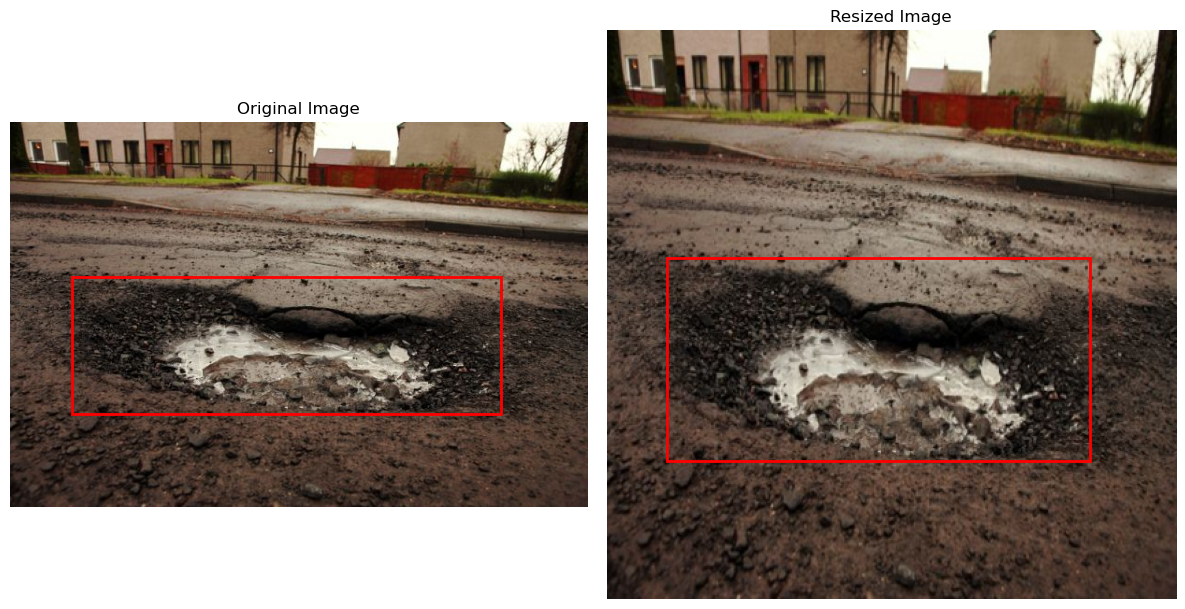

In [7]:
# Testing resized images and boxes with one image
image_path = dataset[225]["image"]
boxes = dataset[225]["boxes"]
original_image = Image.open(image_path)
resized_image, resized_boxes = preprocess_image(image_path, boxes)

compare_images(original_image, boxes, resized_image, resized_boxes)

In [8]:
# Calculate area of bounding boxes (including multiple potholes in one image)
def calculate_area_of_bounding_boxes(original_boxes, resized_boxes, original_image, resized_image):
    severity_list = []

    # original_image_area = original_image.size[0] * original_image.size[1] 
    resized_image_area = resized_image.size[0] * resized_image.size[1]

    for (og_box, box) in zip(original_boxes, resized_boxes):
        # og_xmin, og_ymin, og_xmax, og_ymax = og_box[0], og_box[1], og_box[2], og_box[3]
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        # original_bbox_area = (og_xmax - og_xmin) * (og_ymax - og_ymin)
        resized_bbox_area = (xmax - xmin) * (ymax - ymin)
        percentage = (resized_bbox_area / resized_image_area) * 100
        severity_list.append(severity_thresholds(percentage))
    return severity_list


# Severity thresholds
def severity_thresholds(percentage):
    if percentage > 20:
        return "Immediate Attention"
    elif 10 <= percentage <= 20:
        return "Moderate Attention"
    else:
        return "No Immediate Attention"
    

In [9]:
# Create new XML files with updated details -> image height and width, severity, bounding boxes
updated_xml_dir = "dataset/Updated_XML"
os.makedirs(updated_xml_dir, exist_ok=True)

def create_updated_xml_file(xml_path, resized_image, resized_boxes, severities):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    width, height = resized_image.size

    # Update <size> in XML
    size = root.find("size")
    size.find("width").text = str(width)
    size.find("height").text = str(height)

    objects = root.findall("object")

    if len(objects) != len(resized_boxes):  # Mismatch detected
        print(f"⚠ Warning: {xml_path} has {len(objects)} objects but {len(resized_boxes)} resized boxes")


    # Update bounding boxes
    for i, obj in enumerate(root.findall('object')):
        bndbox = obj.find('bndbox')

        xmin, ymin, xmax, ymax = resized_boxes[i]
        
        # Update the coordinates of each bounding box
        bndbox.find('xmin').text = str(xmin)
        bndbox.find('ymin').text = str(ymin)
        bndbox.find('xmax').text = str(xmax)
        bndbox.find('ymax').text = str(ymax)

    for obj, severity in zip(root.findall("object"), severities):
        severity_element = ET.Element("severity") # Create new Element in XML
        severity_element.text = severity
        
        # Append severity to <object>
        obj.append(severity_element)

    updated_xml_path = os.path.join(updated_xml_dir, os.path.basename(xml_path))
    tree.write(updated_xml_path)

In [10]:
for data, xml_file in zip(dataset, os.listdir(annotation_dir)):
    image_path = data["image"]
    original_boxes = data["boxes"]

    original_image = Image.open(image_path)
    resized_image, resized_boxes = preprocess_image(image_path, original_boxes)

    # Get severity levels
    severities = calculate_area_of_bounding_boxes(original_boxes, resized_boxes, original_image, resized_image)

    # Get corresponding XML file and update it
    xml_path = os.path.join(annotation_dir, xml_file)
    create_updated_xml_file(xml_path, resized_image, resized_boxes, severities)


In [ ]:
# import xml.etree.ElementTree as ET

# def remove_severity_from_xml(annotation_dir):
#     tree = ET.parse(annotation_dir)
#     root = tree.getroot()

#     for obj in root.findall("object"):
#         severity_element = obj.find("severity")
#         if severity_element is not None:
#             obj.remove(severity_element)

#     tree.write(annotation_dir)

# # Remove severity from all XML files
# for data, xml_file in zip(dataset, os.listdir(annotation_dir)):
#     xml_path = os.path.join(annotation_dir, xml_file)
#     remove_severity_from_xml(xml_path)

## Model Training

In [13]:
# Convert XML TO YOLO TXT Format
def convert_xml_to_yolo(annotation_dir, output_dir, image_height, image_width):
    os.makedirs(output_dir, exist_ok=True)

    for xml_file in os.listdir(annotation_dir):
        # Make sure to only use xml files
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(annotation_dir, xml_file))
        root = tree.getroot()
        # Create the .txt file as with the same name as .xml
        text_file_name = os.path.join(output_dir, xml_file.replace(".xml", ".txt"))

        with open(text_file_name, "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_name:
                    continue

                class_id = class_name.index(class_name)
                bbox = obj.find("bndbox")
                xmin, xmax, ymin, ymax = map(int, [bbox.find("xmin").text, bbox.find("ymin").text, bbox.find("xmax").text, bbox.find("ymax").text])

                # Convert to YOLO format 
                x_centre = (xmin + xmax) / (2 * image_width)
                y_centre = (ymin + ymax) / (2 * image_height)
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height

                f.write(f"{class_id} {x_centre:.6f} {y_centre:.6f} {width:.6f} {height:.6f}\n")

    print("Conversion complete!")

def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]

In [14]:
yolo_dir = "dataset/YOLO/"
os.makedirs(yolo_dir, exist_ok=True)

convert_xml_to_yolo(updated_xml_dir, yolo_dir, 416, 416)

Conversion complete!


In [ ]:
# Data Augmentaion
# Enhance the diversity of the data and 

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=416, height=416),
    ToTensorV2(),
])

def augment_image(image, boxes):
    augmented = augmentation(image=image, bboxes=boxes)
    return augmented["image"], augmented["bboxes"]

In [ ]:
# Model training
# Classification accuracy and confustion matrix
# Hyperparameter tuning
# Evaluation
# Visaulisation
# Update ReadME / Documentation